# Learn how to perform regression

We're going to train a neural network that knows how to perform inference in robust linear regression models.
The network will have as input: 

* $x$, a vector of input values, and 
* $y$, a vector of output values.

It will learn how to perform posterior inference for the parameter vector $w$, in a linear regression model.

In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import sys, inspect
sys.path.insert(0, '..')

%matplotlib inline
import pymc
import matplotlib.pyplot as plt

from learn_smc_proposals import cde
from learn_smc_proposals.utils import systematic_resample

import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.markersize": 12})
sns.set_style('ticks')

First step: let's define linear regression as a PyMC model. This model has:

* an intercept term, a linear term, and a quadratic term
* Laplace distribution (double exponential) priors on the weights
* T-distributed (heavy-tailed) likelihoods


In [2]:
num_points = 10 # number of points in the synthetic dataset we train on

def robust_regression(x, t, sigma_0=np.array([10.0, 1.0, .1]), epsilon=1.0):
    """ X: input (NxD matrix)
        t: output (N vector)
        sigma_0: prior std hyperparameter for weights
        epsilon: std hyperparameter for output noise """
    
    if x is not None:
        N, D = x.shape
        assert D == 1
    else:
        N = num_points
        D = 1
    
    # assume our input variable is bounded by some constant
    const = 10.0
    x = pymc.Uniform('x', lower=-const, upper=const, value=x, size=(N, D), observed=(x is not None))
    
    # create design matrix (add intercept)
    @pymc.deterministic(plot=False)
    def X(x=x, N=N):
        return np.hstack((np.ones((N,1)), x, x**2))

    w = pymc.Laplace('w', mu=np.zeros((D+2,)), tau=sigma_0**(-1.0))
    
    @pymc.deterministic(plot=False, trace=False)
    def mu(X=X, w=w):
        return np.dot(X, w)
    
    y = pymc.NoncentralT('y', mu=mu, lam=epsilon**(-2.0), nu=4, value=t, observed=(t is not None))

    return locals()

## Instantiate the generative model

We'll define `M_train`, a PyMC model which doesn't have any data attached.

We can use `M_train.draw_from_prior()` to construct synthetic datasets to use for training.

In [3]:
M_train = pymc.Model(robust_regression(None, None))

def get_observed(model):
    return np.atleast_2d(np.concatenate((model.x.value.ravel(), model.y.value.ravel())))

def get_latent(model):
    return np.atleast_2d(model.w.value)

def generate_synthetic(model, size=100):
    observed, latent = get_observed(model), get_latent(model)
    for i in xrange(size-1):
        model.draw_from_prior()
        observed = np.vstack((observed, get_observed(model)))
        latent = np.vstack((latent, get_latent(model)))
    return observed, latent

gen_data = lambda num_samples: generate_synthetic(M_train, num_samples)
example_minibatch = gen_data(100)



## Define a network which will invert this model

Each of the 3 dimensions of the latent space will be modeled by a mixture of Gaussians.

In [4]:
observed_dim = num_points*2
latent_dim = 3
hidden_units = 300
hidden_layers = 2
mixture_components = 3
dist_est = cde.ConditionalRealValueMADE(observed_dim, latent_dim, hidden_units, hidden_layers, mixture_components)
if torch.cuda.is_available():
    dist_est.cuda()

dist_est

ConditionalRealValueMADE (
  (relu): ReLU ()
  (softplus): Softplus (beta=1, threshold=20)
  (layers): ModuleList (
    (0): MaskedLinear (23 -> 300)
    (1): MaskedLinear (300 -> 300)
  )
  (skip_alpha): ModuleList (
    (0): MaskedLinear (23 -> 3)
    (1): MaskedLinear (23 -> 3)
    (2): MaskedLinear (23 -> 3)
  )
  (skip_mu): ModuleList (
    (0): MaskedLinear (23 -> 3)
    (1): MaskedLinear (23 -> 3)
    (2): MaskedLinear (23 -> 3)
  )
  (skip_sigma): ModuleList (
    (0): MaskedLinear (23 -> 3)
    (1): MaskedLinear (23 -> 3)
    (2): MaskedLinear (23 -> 3)
  )
  (alpha): ModuleList (
    (0): MaskedLinear (300 -> 3)
    (1): MaskedLinear (300 -> 3)
    (2): MaskedLinear (300 -> 3)
  )
  (mu): ModuleList (
    (0): MaskedLinear (300 -> 3)
    (1): MaskedLinear (300 -> 3)
    (2): MaskedLinear (300 -> 3)
  )
  (sigma): ModuleList (
    (0): MaskedLinear (300 -> 3)
    (1): MaskedLinear (300 -> 3)
    (2): MaskedLinear (300 -> 3)
  )
)

### We can use our network to sample and to compute logpdfs.

The primary interface is through `.sample(parents)`, and `.logpdf(parents, latent)`.

Both of these expect pytorch tensors as inputs.

In [5]:
example_parents = Variable(torch.FloatTensor(example_minibatch[0][:5]))
example_latents = Variable(torch.FloatTensor(example_minibatch[1][:5]))
if torch.cuda.is_available():
    example_parents = example_parents.cuda()
    example_latents = example_latents.cuda()

print "Sampled from p(latent|parents):\n\n", dist_est.sample(example_parents)
print "Evaluate log p(latent|parents):\n\n", dist_est.logpdf(example_parents, example_latents)

Sampled from p(latent|parents):

Variable containing:
 0.4480  0.2449 -0.2478
 0.1673 -0.8695 -0.4048
-1.1738  1.3328 -0.7874
 0.1154  1.0899 -0.9668
-0.3404 -0.5039  0.3903
[torch.cuda.FloatTensor of size 5x3 (GPU 0)]

Evaluate log p(latent|parents):

Variable containing:
 -35.4653
 -97.4705
-197.2146
  -9.5569
  -6.1380
[torch.cuda.FloatTensor of size 5x1 (GPU 0)]



## Optimize network parameters

The `training_epoch` code samples a synthetic dataset, and performs minibatch updates on it for a while. Optionally, it can decide when to stop by examining synthetic validation data.

In [6]:
def _iterate_minibatches(inputs, outputs, batchsize):
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        excerpt = slice(start_idx, start_idx + batchsize)
        yield Variable(torch.FloatTensor(inputs[excerpt])), Variable(torch.FloatTensor(outputs[excerpt]))

def training_step(optimizer, dist_est, gen_data, dataset_size, batch_size, max_local_iters=10, misstep_tolerance=0, verbose=False):
    """ Training function for fitting density estimator to simulator output """
    # Train
    synthetic_ins, synthetic_outs = gen_data(dataset_size)
    validation_size = dataset_size/10
    validation_ins, validation_outs = [Variable(torch.FloatTensor(t)) for t in gen_data(validation_size)]
    missteps = 0
    num_batches = float(dataset_size)/batch_size
    
    USE_GPU = dist_est.parameters().next().is_cuda
    if USE_GPU:
        validation_ins = validation_ins.cuda()
        validation_outs = validation_outs.cuda()
    
    validation_err = -torch.mean(dist_est.logpdf(validation_ins, validation_outs)).data[0]
    for local_iter in xrange(max_local_iters):
        
        train_err = 0 
        for inputs, outputs in _iterate_minibatches(synthetic_ins, synthetic_outs, batch_size):
            optimizer.zero_grad()
            if USE_GPU:
                loss = -torch.mean(dist_est.logpdf(inputs.cuda(), outputs.cuda()))
            else:
                loss = -torch.mean(dist_est.logpdf(inputs, outputs))
            loss.backward()
            optimizer.step()
            train_err += loss.data[0]/num_batches
            
        next_validation_err = -torch.mean(dist_est.logpdf(validation_ins, validation_outs)).data[0]
        if next_validation_err > validation_err:
            missteps += 1
        validation_err = next_validation_err
        if missteps > misstep_tolerance:
            break

    if verbose:
        print train_err, validation_err, "(", local_iter+1, ")"
        
    return train_err, validation_err, local_iter+1

In [7]:
optimizer = torch.optim.Adam(dist_est.parameters())
trace_train = []
trace_validation = []
trace_local_iters = []

In [8]:
num_iterations = 500
dataset_size = 2500
batch_size = 250

for i in xrange(num_iterations):
    verbose = (i+1) % 25 == 0
    if verbose:
        print "["+str(1+len(trace_train))+"]",
    t,v,l = training_step(optimizer, dist_est, gen_data, dataset_size, batch_size, verbose=verbose)
    trace_train.append(t)
    trace_validation.append(v)
    trace_local_iters.append(l)

[25] 1.4739862442 1.39473605156 ( 3 )
[50] 0.975032299757 1.4387845993 ( 3 )
[75] 0.813962358236 1.16537082195 ( 2 )
[100] 0.706842708588 0.72219979763 ( 2 )
[125] 0.484182612598 0.600739479065 ( 4 )
[150] 0.647036370635 0.826664030552 ( 1 )
[175] -0.234826402366 0.426864027977 ( 3 )
[200] -0.215777371079 -0.118048891425 ( 1 )
[225] -0.476245886087 -0.447725445032 ( 1 )
[250] -0.80267406702 -0.116454035044 ( 2 )
[275] -1.03359056935 2.83821463585 ( 4 )
[300] -0.790694701672 -0.888925611973 ( 1 )
[325] -1.23384248018 -0.678227901459 ( 2 )
[350] -1.44092001915 -0.841804563999 ( 3 )
[375] -0.819214296341 -0.951810061932 ( 1 )
[400] 0.291132071614 0.125569283962 ( 1 )
[425] -1.33743433952 -0.770213425159 ( 4 )
[450] -1.283076334 -1.01444149017 ( 2 )
[475] -1.48304002285 -0.669151961803 ( 4 )
[500] -1.18863228559 -1.51894629002 ( 1 )


/home/brooks/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


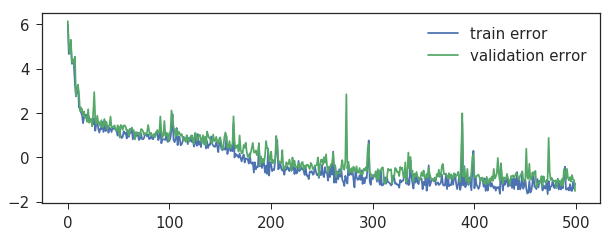

In [9]:
plt.figure(figsize=(10,3.5))
plt.plot(np.array(trace_train))
plt.plot(np.array(trace_validation))
plt.legend(['train error', 'validation error']);

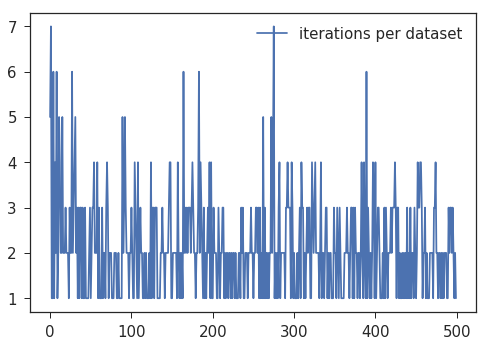

In [10]:
plt.plot(np.array(trace_local_iters))
plt.legend(['iterations per dataset'])

## Define plotting and testing functions

We'll use PyMC's default Metropolis-Hastings as a benchmark, and compare to sampling directly from the learned model, and importance sampling.

In [11]:
def gen_example_pair(model):
    model.draw_from_prior()
    data_x = model.X.value
    data_y = model.y.value
    true_w = model.w.value
    return data_x, data_y, true_w

def estimate_MCMC(data_x, data_y, ns, iters=10000, burn=0.5):
    """ MCMC estimate of weight distribution """
    mcmc_est = pymc.MCMC(robust_regression(data_x[:,1:2], data_y))
    mcmc_est.sample(iters, burn=burn*iters, thin=np.ceil(burn*iters/ns))
    trace_w = mcmc_est.trace('w').gettrace()[:ns]
    return trace_w

def estimate_NN(network, data_x, data_y, ns):
    """ NN proposal density for weights """
    nn_input = Variable(torch.FloatTensor(np.concatenate((data_x[:,1], data_y[:]))))
    print nn_input.size()
    nn_input = nn_input.unsqueeze(0).repeat(ns,1)
    if network.parameters().next().is_cuda:
        nn_input = nn_input.cuda()
    values, log_q = network.propose(nn_input)
    return values.cpu().data.numpy(), log_q.squeeze().cpu().data.numpy()

def sample_prior_proposals(model, ns):
    samples = []
    for n in xrange(ns):
        model.draw_from_prior()
        samples.append(model.w.value)
    return np.array(samples)

def compare_and_plot(ns=100, alpha=0.05, data_x=None, data_y=None, true_w=None):
    model = pymc.Model(robust_regression(None, None))
    prior_proposals = sample_prior_proposals(model, ns*10)
    if data_x is None:
        data_x, data_y, true_w = gen_example_pair(model)
    mcmc_trace = estimate_MCMC(data_x, data_y, ns)
    nn_proposals, logq = estimate_NN(dist_est, data_x, data_y, ns*10)
    mcmc_mean = mcmc_trace.mean(0)
    nn_mean = nn_proposals.mean(0)
    print
    print "True (generating) w:", true_w
    print "MCMC weight mean:", mcmc_mean
    print "NN weight proposal mean:", nn_mean
    
    domain = np.linspace(min(data_x[:,1])-2, max(data_x[:,1])+2, 50)
    plt.figure(figsize=(14,3))
    plt.subplot(141)

    plt.plot(domain, mcmc_mean[0] + mcmc_mean[1]*domain + mcmc_mean[2]*domain**2, "b--")
    for i in range(ns):
        plt.plot(domain, mcmc_trace[i,0] + mcmc_trace[i,1]*domain + mcmc_trace[i,2]*domain**2, "b-", alpha=alpha)
    plt.plot(data_x[:,1], data_y, "k.")
    plt.xlim(np.min(domain),np.max(domain))
    limy = plt.ylim()
    plt.legend(["MH posterior"])

    ax = plt.subplot(143)
    plt.plot(domain, nn_mean[0] + nn_mean[1]*domain + nn_mean[2]*domain**2, "r--")
    for i in range(ns):
        plt.plot(domain, nn_proposals[i,0] + nn_proposals[i,1]*domain  + nn_proposals[i,2]*domain**2, "r-", alpha=alpha)
    plt.plot(data_x[:,1], data_y, "k.")
    plt.legend(["NN proposal"])
    plt.ylim(limy)
    plt.xlim(min(domain),max(domain));
    ax.yaxis.set_ticklabels([])
    
    ax = plt.subplot(142)
    prior_samples_mean = prior_proposals.mean(0)
    prior_proposals = prior_proposals[::10]
    plt.plot(domain, prior_samples_mean[0] + prior_samples_mean[1]*domain + prior_samples_mean[2]*domain**2, "c--")
    for i in range(ns):
        plt.plot(domain, prior_proposals[i,0] + prior_proposals[i,1]*domain  + prior_proposals[i,2]*domain**2, "c-", alpha=alpha)
    plt.plot(data_x[:,1], data_y, "k.")
    plt.legend(["Prior"])
    plt.ylim(limy)
    plt.xlim(min(domain),max(domain));    
    ax.yaxis.set_ticklabels([])

    # compute NN-IS estimate
    logp = []
    nn_test_model = pymc.Model(robust_regression(data_x[:,1:2], data_y))
    for nnp in nn_proposals:
        nn_test_model.w.value = nnp
        try:
            next_logp = nn_test_model.logp
        except:
            next_logp = -np.Inf
        logp.append(next_logp)
    logp = np.array(logp)
    w = np.exp(logp - logq) / np.sum(np.exp(logp - logq))
    nnis_mean = np.sum(w*nn_proposals.T,1)
    print "NN-IS estimated mean:", nnis_mean
    print "NN-IS ESS:", 1.0/np.sum(w**2), w.shape[0]
    
    ax = plt.subplot(144)
    plt.plot(domain, nnis_mean[0] + nnis_mean[1]*domain + nnis_mean[2]*domain**2, "g--")
    
    nn_resampled = nn_proposals[systematic_resample(np.log(w))][::10]
    for i in range(ns):
        plt.plot(domain, nn_resampled[i,0] + nn_resampled[i,1]*domain  + nn_resampled[i,2]*domain**2, "g-", alpha=alpha)
    plt.plot(data_x[:,1], data_y, "k.")
    plt.legend(["NN-IS posterior"])
    plt.ylim(limy)
    plt.xlim(min(domain),max(domain));
    ax.yaxis.set_ticklabels([])
    
    plt.tight_layout()

 [-----------------100%-----------------] 10000 of 10000 complete in 0.7 sectorch.Size([20])

True (generating) w: [ 4.73991354  0.74054074 -0.30554276]
MCMC weight mean: [ 5.14623788  0.67354519 -0.28866678]
NN weight proposal mean: [ 5.71999454  0.42607185 -0.26677647]
NN-IS estimated mean: [ 5.26128382  0.63550466 -0.28525228]
NN-IS ESS: 128.512344583 1000


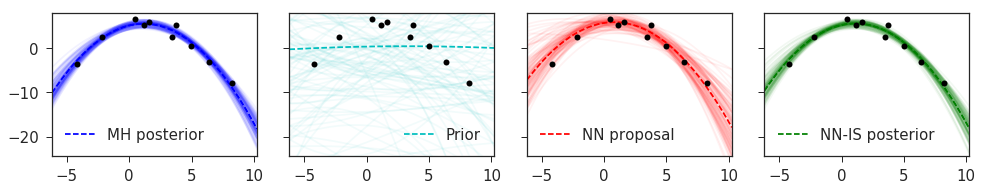

In [12]:
compare_and_plot();

 [-----------------100%-----------------] 10000 of 10000 complete in 0.7 sectorch.Size([20])

True (generating) w: [-0.78617364 -0.50516593 -0.08651312]
MCMC weight mean: [-0.57442949 -0.40994035 -0.0910256 ]
NN weight proposal mean: [-1.75112629 -0.40937507 -0.06389721]
NN-IS estimated mean: [-0.68387323 -0.40709151 -0.09104877]
NN-IS ESS: 102.536155012 1000


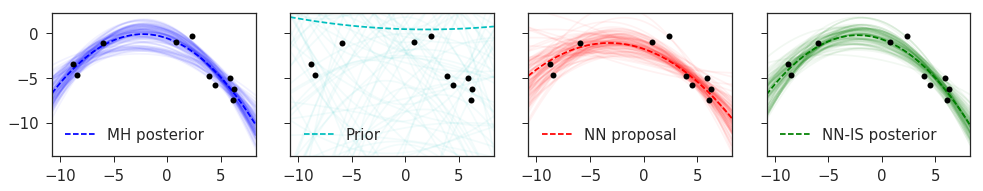

In [13]:
compare_and_plot();

 [-----------------100%-----------------] 10000 of 10000 complete in 0.7 sectorch.Size([20])

True (generating) w: [ 1.41710747  1.4033312   0.01209659]
MCMC weight mean: [ 1.83809801  1.35969496 -0.00692921]
NN weight proposal mean: [ 1.43908763  1.34977925  0.01362366]
NN-IS estimated mean: [ 1.86267268  1.34957003 -0.00703505]
NN-IS ESS: 327.759680341 1000


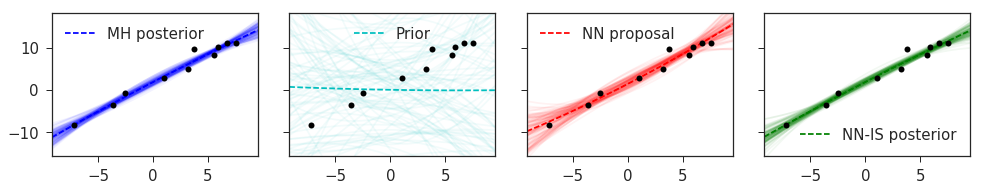

In [14]:
compare_and_plot();

 [-----------------100%-----------------] 10000 of 10000 complete in 0.7 sectorch.Size([20])

True (generating) w: [ 3.60761251  0.72078341 -0.02210601]
MCMC weight mean: [ 3.91584286  0.69619799 -0.02571687]
NN weight proposal mean: [ 4.35619831  0.70587444 -0.04962742]
NN-IS estimated mean: [ 3.95620388  0.69779208 -0.02682442]
NN-IS ESS: 238.376812052 1000


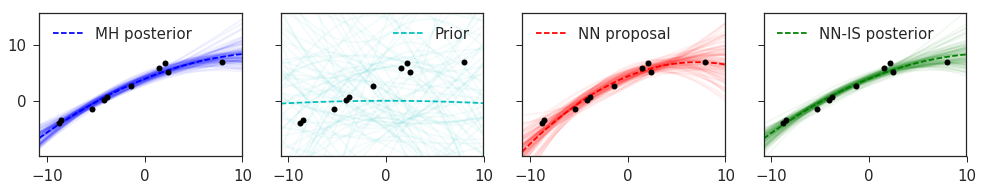

In [15]:
compare_and_plot();

 [-----------------100%-----------------] 10000 of 10000 complete in 0.7 sectorch.Size([20])

True (generating) w: [ 7.63904901 -0.36557729 -0.07160346]
MCMC weight mean: [ 0.22873088 -0.26250082  0.10648334]
NN weight proposal mean: [ 8.32784653 -0.37608653 -0.07719008]
NN-IS estimated mean: [ 7.75216888 -0.43988078 -0.07876221]
NN-IS ESS: 226.696671634 1000


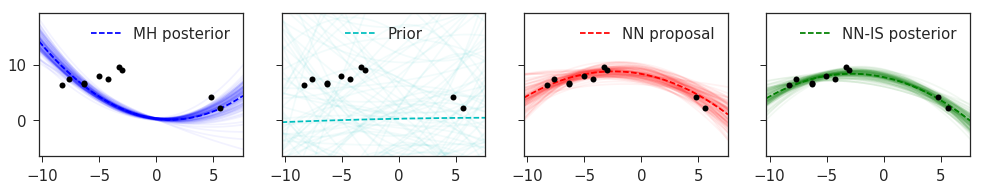

In [16]:
compare_and_plot();